# Set up the working directory and enviroment

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
import os
os.chdir("/content/drive/Shared drives/CARD/projects/iNDI/line_prioritization/projects_lirong/pool1_hNIL")

## Assign folders for storing input data, object, and output
1. 'data' folder: storing .mtx or h5 from 10xGenomic sequencing 
2. 'interim' folder: storing h5ad object after processing and its output files, e.g., top_markers.csv
3. 'figures' folder: automatically generated

In [9]:
%ls

filtered_feature_bc_matrix/    possorted_genome_bam.bam      scanpy_out/
filtered_feature_bc_matrix.h5  possorted_genome_bam.bam.bai


In [0]:
#! mkdir scanpy_out
results_file = 'scanpy_out/pool1_hNIL.h5ad'

## Installed the required packages

In [0]:
# required for umap clustering
! pip3 install leidenalg 
! pip3 install scanpy
# ! pip install python-igraph
# ! pip install louvain
import h5py
import numpy as np
import pandas as pd
import scanpy as sc

## Set up the displaying and print parameters

In [12]:
sc.settings.verbosity = 3 
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.10.2 python-igraph==0.8.0


# Data preprocessing
1. Use gene symbols for the variable names (variables-axis index)
3. Write a cache file for faster subsequent reading
4. De-duplicates

## Read 10xGenomics sc-RNA sequencing data

In [13]:
adata = sc.read_10x_h5("filtered_feature_bc_matrix.h5")                               

reading filtered_feature_bc_matrix.h5


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


 (0:00:04)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [0]:
adata.var_names_make_unique()

In [15]:
adata

AnnData object with n_obs × n_vars = 7915 × 33538 
    var: 'gene_ids', 'feature_types', 'genome'

## Basic filtering
1. cell based filtering: remove cells with less than 200 genes
2. gene based filtering: remove genes expressing in less than 3 cells

In [16]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 13563 genes that are detected in less than 3 cells


## Calculate the percentage of mitochondrial genes

In [0]:
mito_genes = adata.var_names.str.startswith('MT-')

adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1

adata.obs['n_counts'] = adata.X.sum(axis=1).A1

## Check sequencing quality
1. choose the threthold of gene numbers to remove, e.g., n_genes = 4500
2. choose the threthold of mitochondial genes to remove, e.g., percent_mito = 0.15

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
... storing 'feature_types' as categorical
... storing 'genome' as categorical


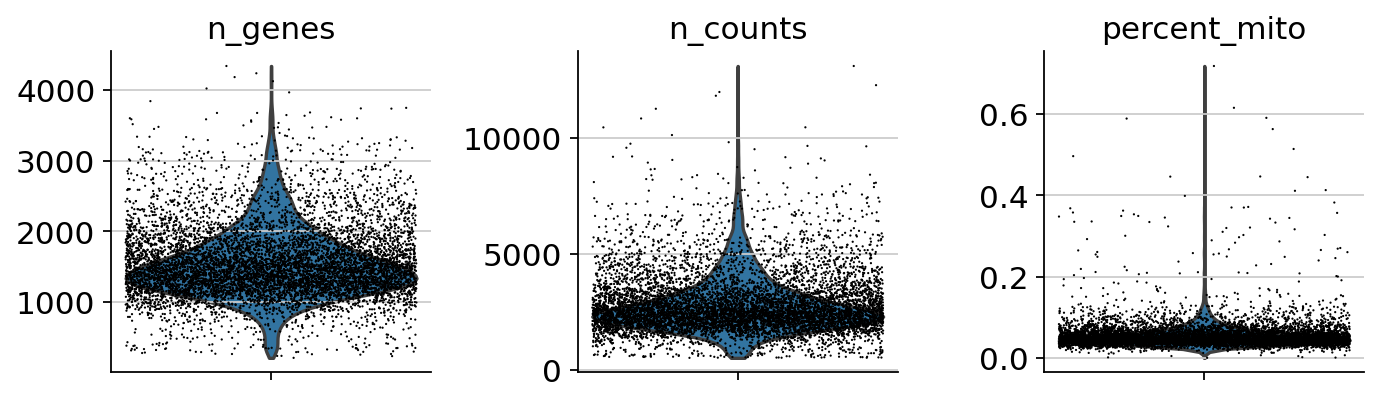

In [18]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

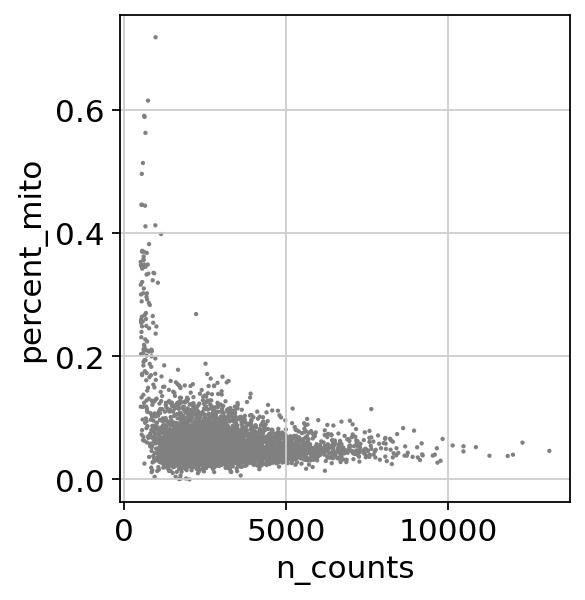

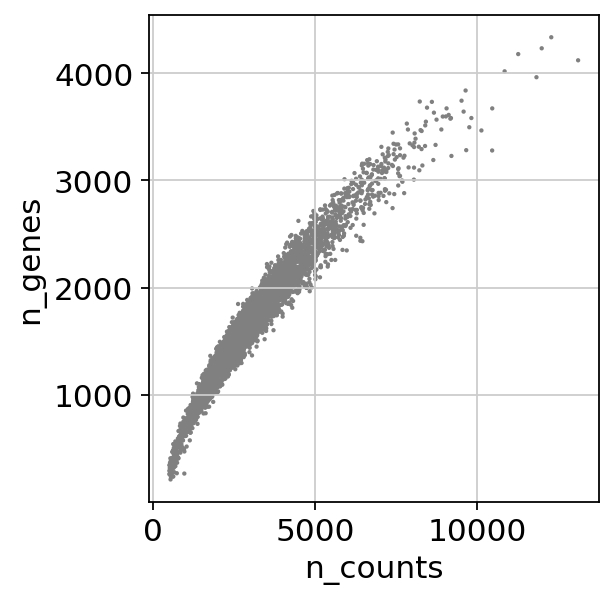

In [19]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [20]:
adata = adata[adata.obs.n_genes < 4500, :]
adata = adata[adata.obs.percent_mito < 0.15, :]
adata

View of AnnData object with n_obs × n_vars = 7797 × 19975 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells'

## Scale and logarithmize the data
option: store the unnormalized data in .raw

In [21]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw=adata

normalizing counts per cell
    finished (0:00:10)


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_simple.py:297: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(data)


## Choosing highly-variable genes for further analysis
Subset is optional. If subset using adata.var.highly_variable, the adata will only contain these genes.

This time, let's try do not subset

In [22]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


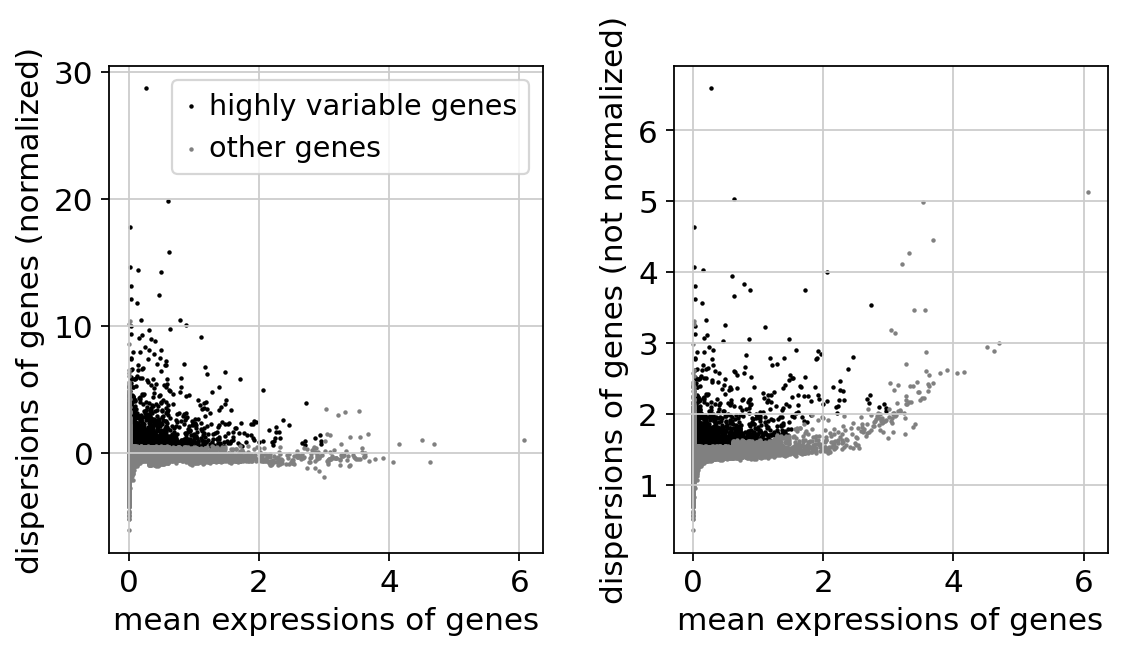

In [23]:
sc.pl.highly_variable_genes(adata)

In [24]:
adata = adata[:, adata.var.highly_variable]
adata

View of AnnData object with n_obs × n_vars = 7797 × 1998 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p'

## Further scale on cofounder "n_counts" and "percent_mito"
1. Regression out n_counts and percent_mito effect and scale again on adata which only contains highly-variable genes now.
2. Clip values exceeding standard deviation 10 (max_value=10)

In [25]:
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:18)


# Principal component analysis

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:02)


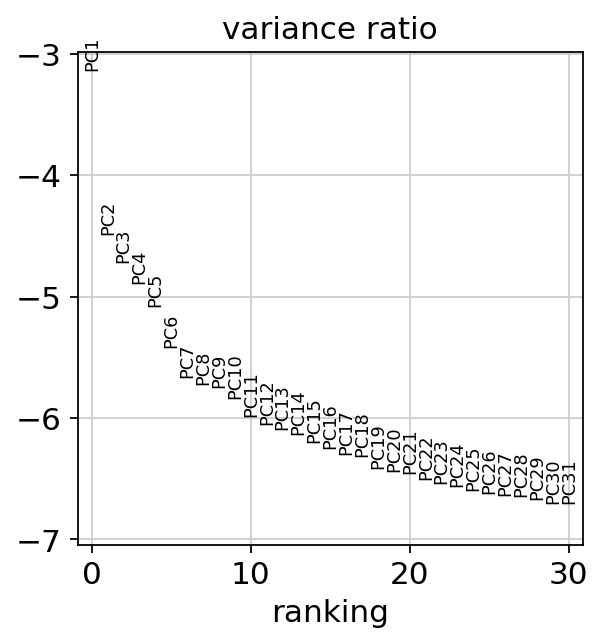

    on highly variable genes
computing PCA with n_comps = 50


In [26]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [0]:
adata.write_h5ad("pool1_hNIL_before_neighbors.h5ad")


### Computing, embedding, and clustering the neighborhood graph

1. Computing the neighborhood graph of cells using the PCA representation of the data matrix.
2. Embedding the graph in 2 dimensions using UMAP.
3. Clustering the neighborhood graph using Leiden graph-clustering method 

In [29]:
 # defaults are: n_neighbors= 20, n_pcs=50
sc.pp.neighbors(adata)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:23)


In [30]:
# default resolution=1.0
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


In [31]:
adata

AnnData object with n_obs × n_vars = 7797 × 1998 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [32]:
sc.tl.leiden(adata, resolution=0.4, key_added = "leiden_0.4")
sc.tl.leiden(adata, resolution=0.6, key_added = "leiden_0.6")

running Leiden clustering
    finished: found 9 clusters and added
    'leiden_0.4', the cluster labels (adata.obs, categorical) (0:00:01)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden_0.6', the cluster labels (adata.obs, categorical) (0:00:01)


## Visualize the clusters

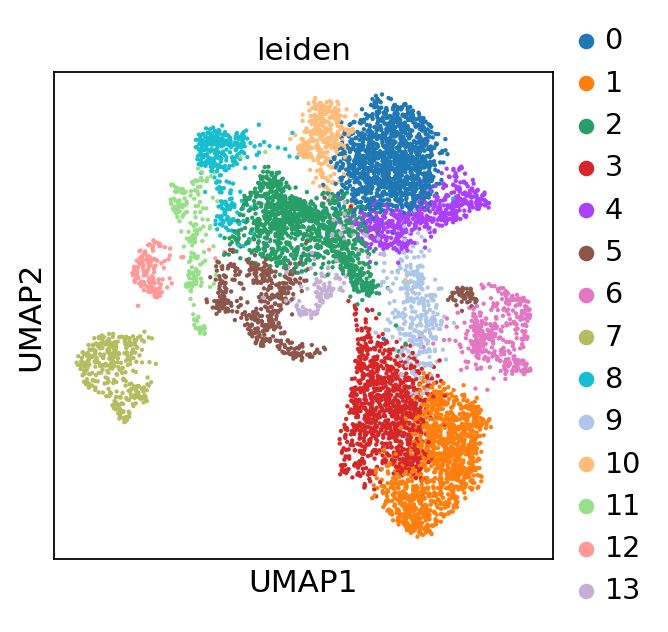

In [33]:
sc.pl.umap(adata, color=['leiden'])

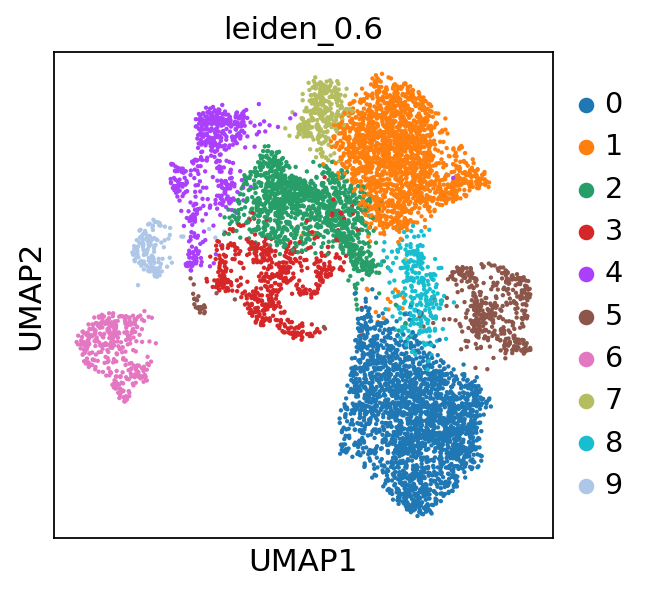

In [34]:
sc.pl.umap(adata, color=['leiden_0.6'])

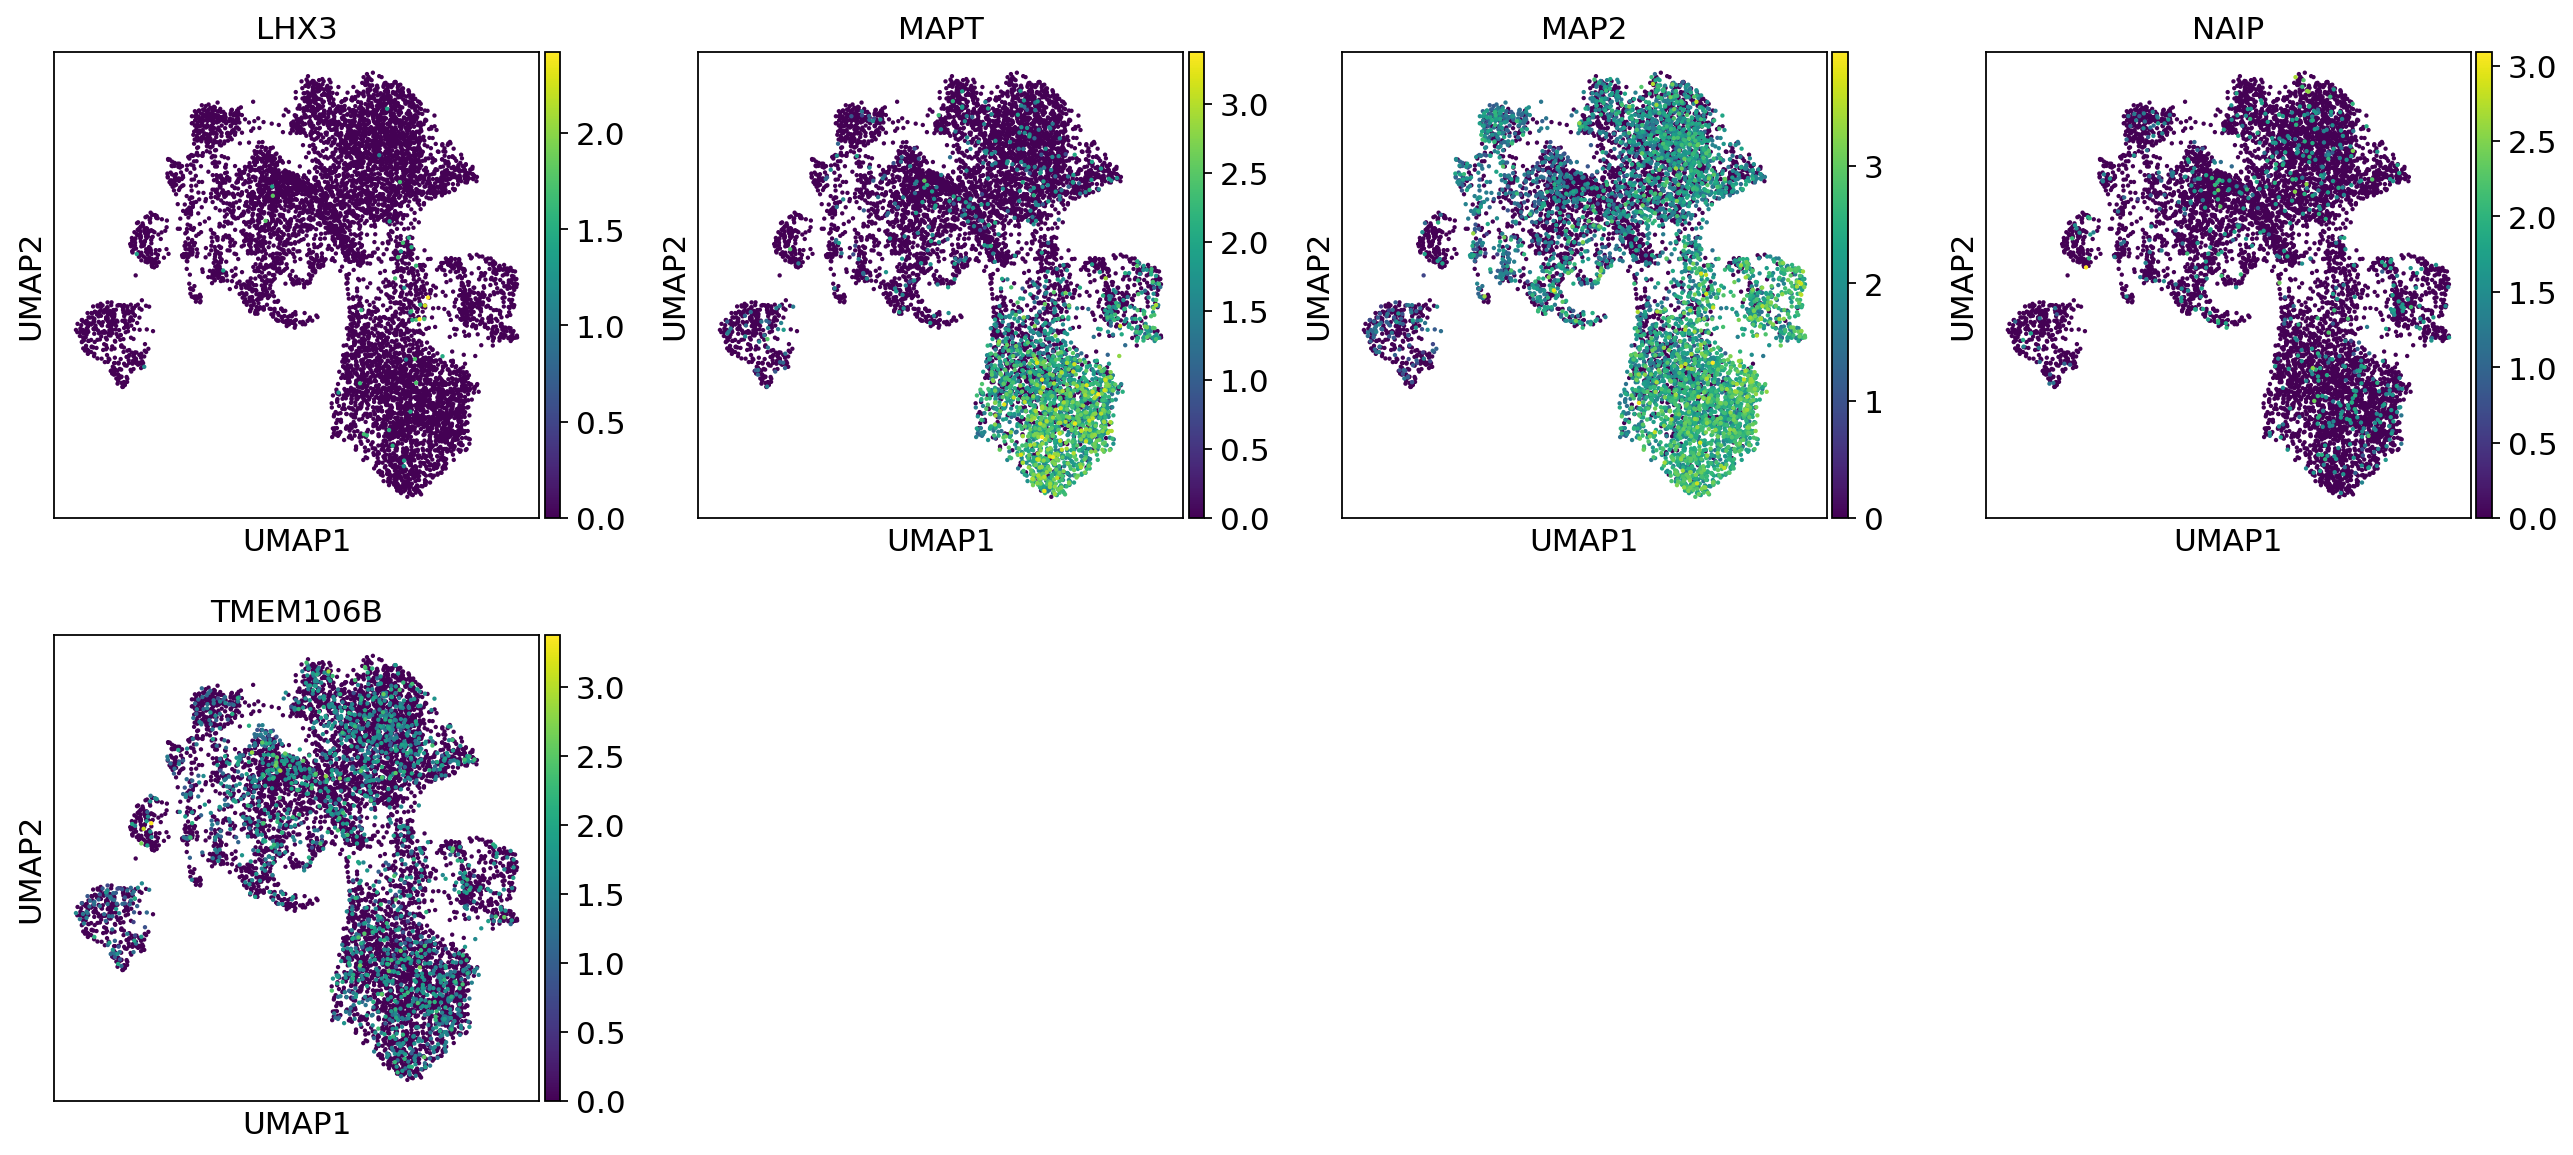

In [41]:
sc.pl.umap(adata, color=['LHX3','MAPT','MAP2', 'NAIP', 'TMEM106B'])

## Save the processed adata object saved as .h5ad
The object can be load using adata = sc.read(results_file)

In [0]:
adata.write(results_file)

# Finding marker genes
one vs rest comparison using Mann-Whitney-U-test (recommend)

In [0]:
# reduce the verbosity from 3 to 2 in the setting of logging output
sc.settings.verbosity = 2 

ranking genes
    finished (0:00:11)


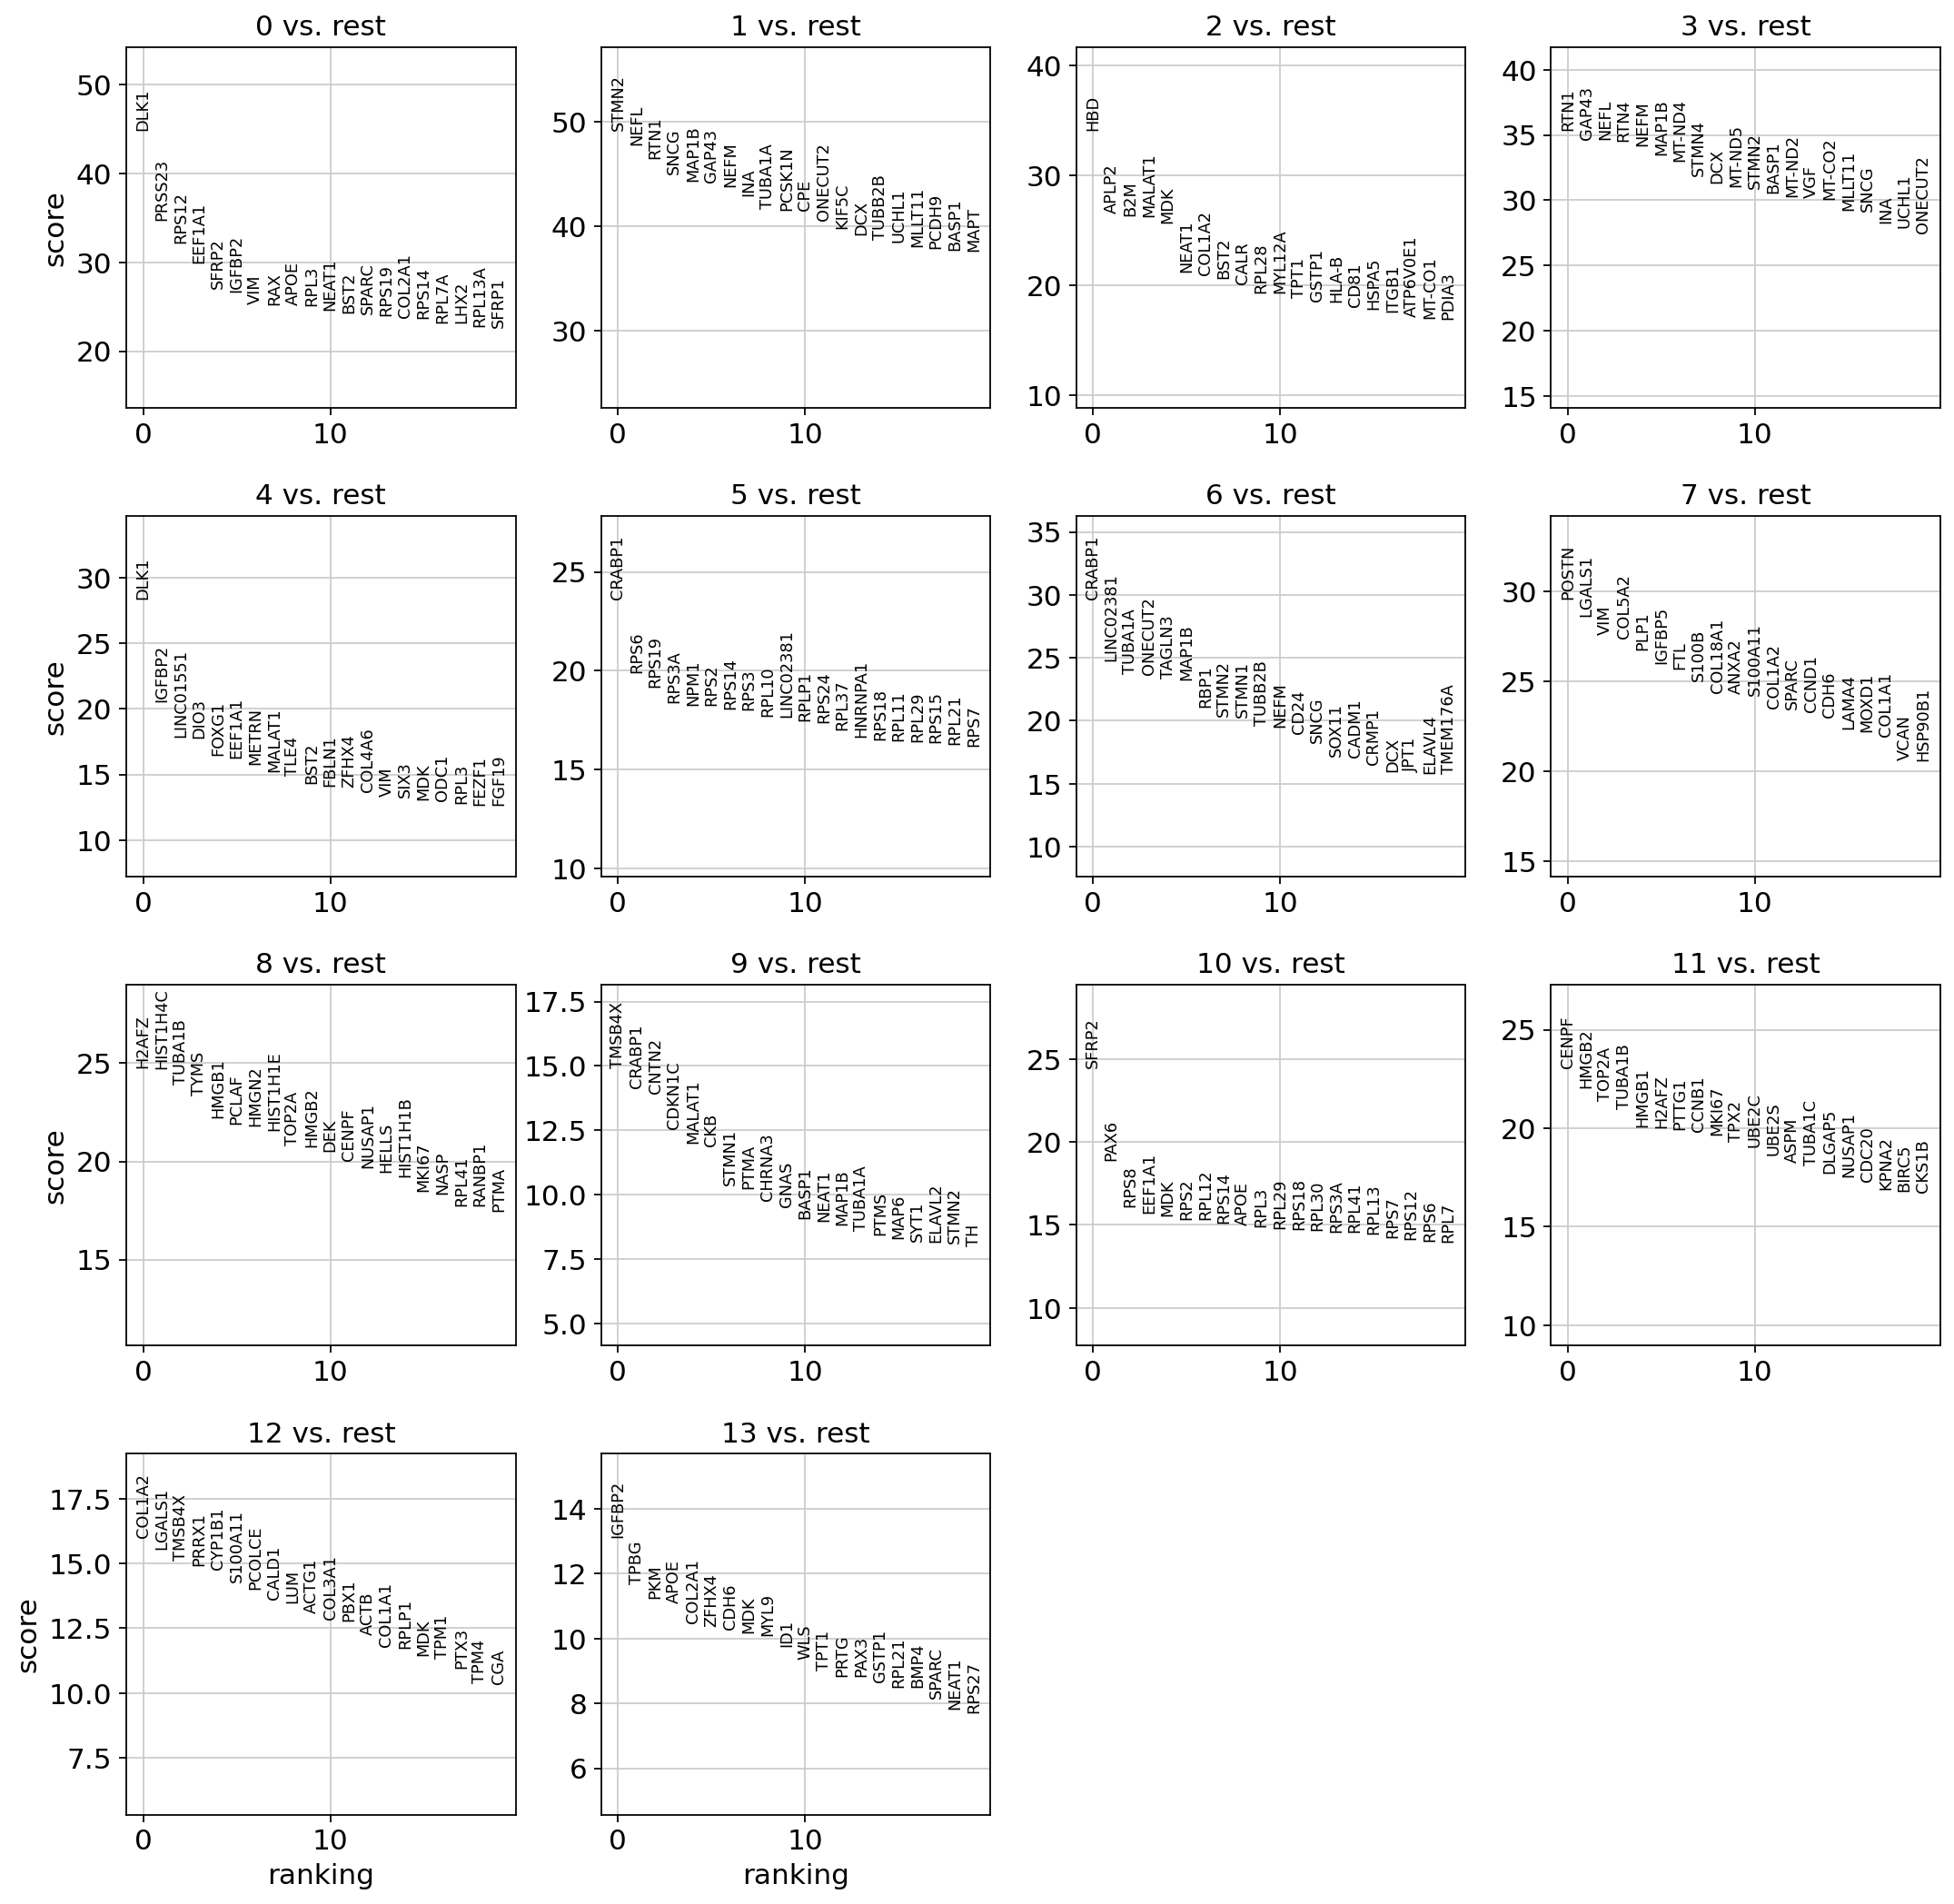

In [43]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

## Visualize the differential expression of marker genes across clusters
1. Differential expression a set of marker genes of a specific cluster vs the rest.
2. Differential expression of a single gene across all clusters

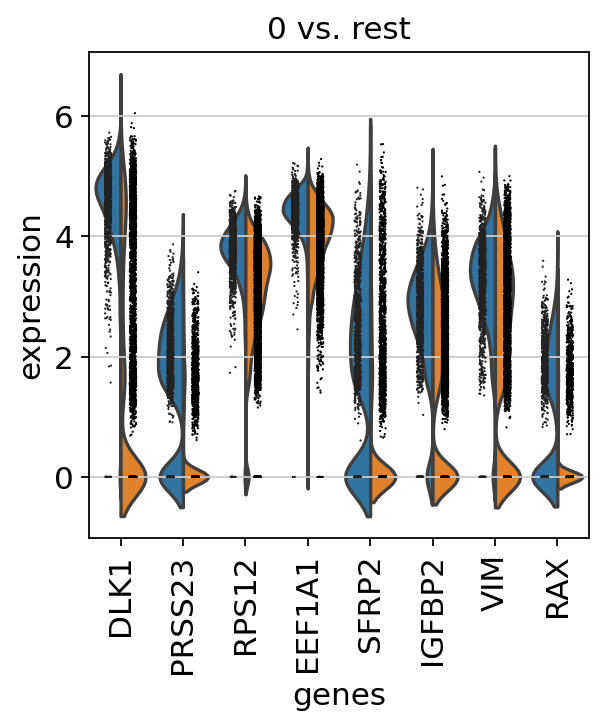

In [45]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

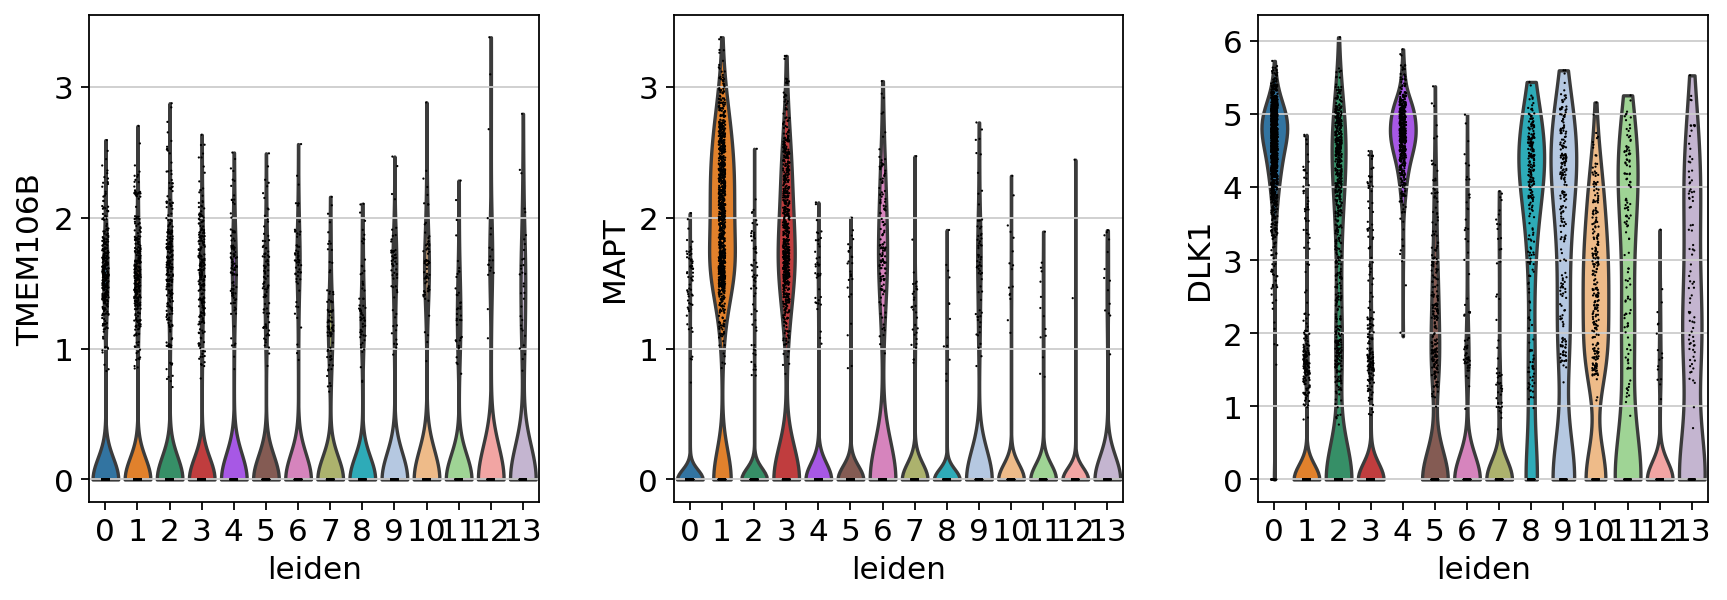

In [50]:
sc.pl.violin(adata, ['TMEM106B', 'MAPT', "DLK1"], groupby='leiden')

## Annotate cell types for all the clusters 
Based on domain knowledge and information of marker genes

Wait for disscussion for this case


In [0]:
# assign cell type names to the clusters
# new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']

# adata.rename_categories('leiden', new_cluster_names)

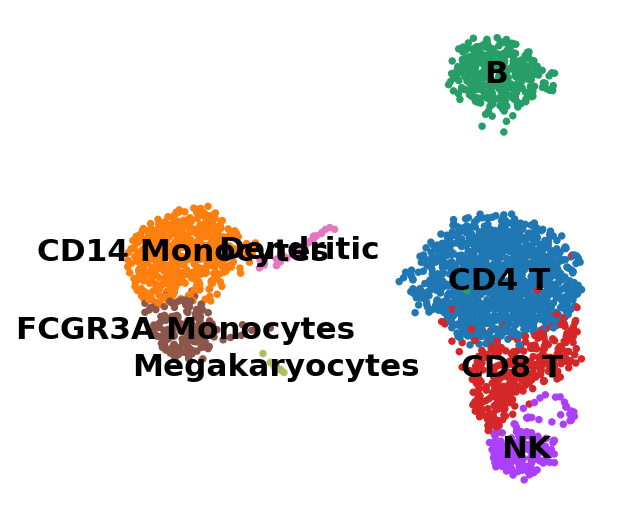

In [0]:
# it automatically generates a folder of 'figures' and save the figure inside 
# sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

# Export a list of marker genes

In [0]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_marker_genes = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(50)

top_marker_genes.to_csv('scanpy_out/top_markers_pool1_neurons_hNGN2_HVG.csv')

In [49]:
top_marker_genes.head()

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p,8_n,8_p,9_n,9_p,10_n,10_p,11_n,11_p,12_n,12_p,13_n,13_p
0,DLK1,0.000000e+00,STMN2,0.0,HBD,2.695918e-254,RTN1,1.264832e-273,DLK1,1.197591e-176,CRABP1,2.859839e-123,CRABP1,3.988759e-193,POSTN,3.787022e-192,H2AFZ,3.349741e-135,TMSB4X,2.679783e-50,SFRP2,7.030374e-132,CENPF,1.627766e-117,COL1A2,9.289795e-58,IGFBP2,2.220623e-39
1,PRSS23,6.116401e-264,NEFL,0.0,APLP2,4.058069e-155,GAP43,4.802609e-263,IGFBP2,9.123889e-94,RPS6,5.916190e-88,LINC02381,1.394224e-135,LGALS1,4.846675e-180,HIST1H4C,7.369169e-135,CRABP1,2.287094e-45,PAX6,1.201562e-79,HMGB2,1.309285e-107,LGALS1,1.877520e-54,TPBG,1.628921e-31
2,RPS12,1.436545e-227,RTN1,0.0,B2M,8.856704e-153,NEFL,1.029404e-262,LINC01551,3.990023e-71,RPS19,8.202219e-82,TUBA1A,2.952980e-124,VIM,1.373109e-167,TUBA1B,1.003747e-126,CNTN2,3.345961e-44,RPS8,3.526548e-58,TOP2A,1.801836e-101,TMSB4X,1.278499e-51,PKM,2.675472e-29
3,EEF1A1,1.580820e-196,SNCG,0.0,MALAT1,1.165461e-151,RTN4,3.349503e-261,DIO3,7.617674e-71,RPS3A,1.568741e-75,ONECUT2,1.393530e-123,COL5A2,1.245077e-165,TYMS,8.553869e-121,CDKN1C,2.672809e-36,EEF1A1,1.482115e-55,TUBA1B,6.890297e-98,PRRX1,2.772255e-50,APOE,1.197228e-28
4,SFRP2,2.594480e-161,MAP1B,0.0,MDK,4.407402e-145,NEFM,2.414113e-255,FOXG1,5.671031e-61,NPM1,2.464159e-74,TAGLN3,6.599625e-121,PLP1,1.903108e-157,HMGB1,2.028394e-109,MALAT1,3.596295e-33,MDK,1.504080e-54,HMGB1,1.348784e-89,CYP1B1,2.767926e-49,COL2A1,9.015194e-26


In [0]:
# get a list of top20 marker genes of cluster 1
marker_genes_cluster1 = top_marker_genes["1_n"][:20].values

# Visulize gene differential expression 
maker genes or other gene of interest


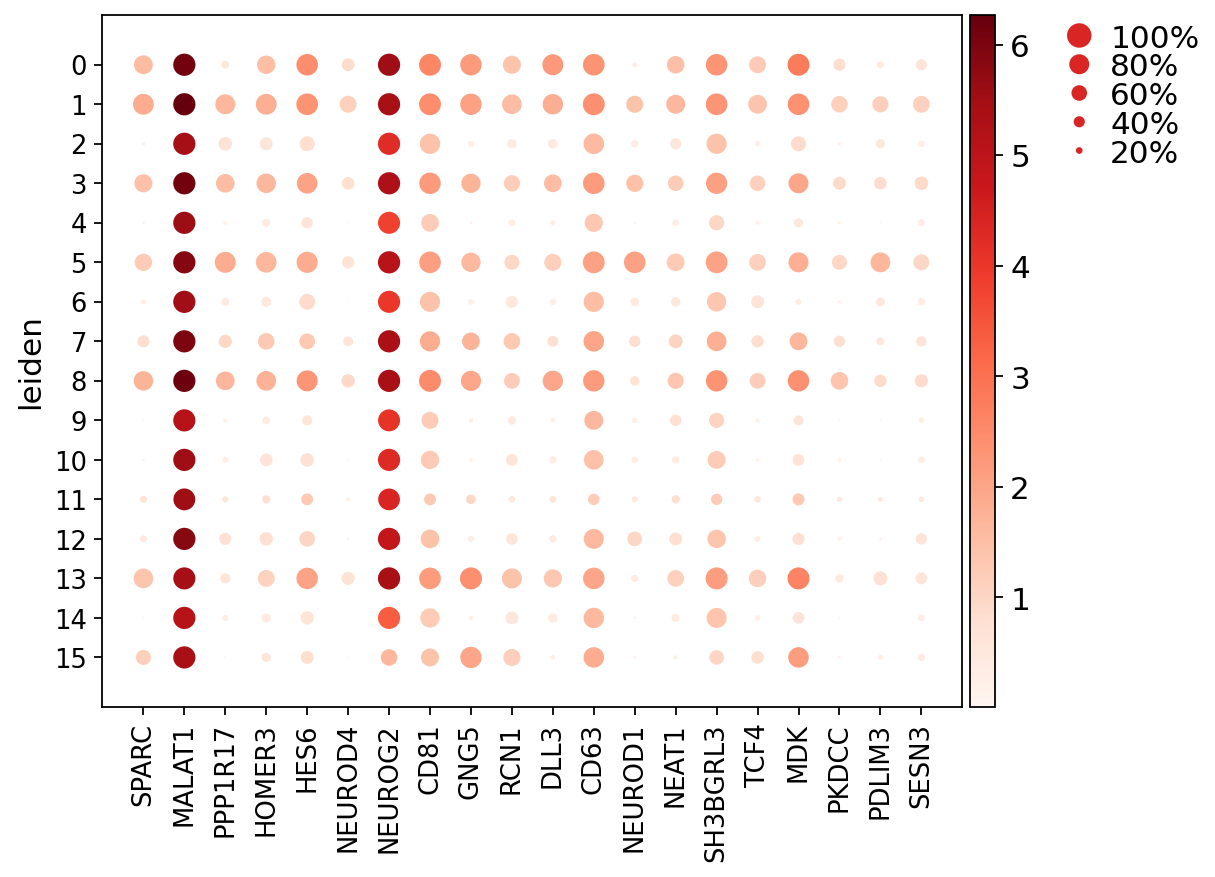

In [0]:
ax = sc.pl.dotplot(adata, marker_genes_cluster1, groupby='leiden')

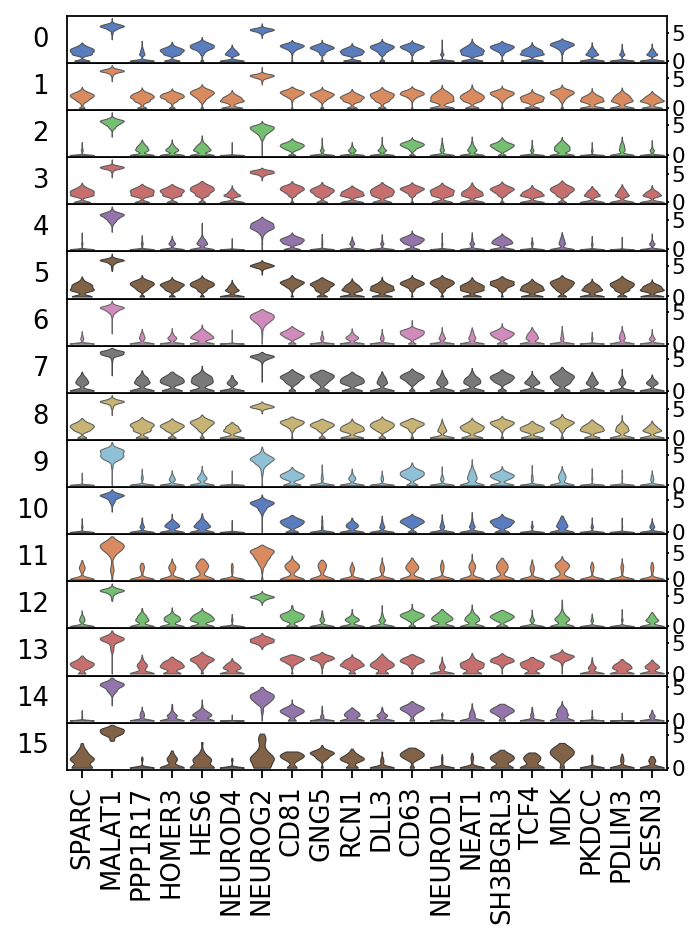

In [0]:
ax = sc.pl.stacked_violin(adata, marker_genes_cluster1, groupby='leiden', rotation=90)

# Save the work
option: export a set of csv using 
adata.write_csvs(results_file[:-5])

In [0]:
adata.write(results_file)

In [0]:
%ls

analysis_10xgenomics/        filtered_feature_bc_matrix.h5  scanpy_out/
barcodes.tsv.gz              possorted_genome_bam.bam       web_summary.html
filtered_feature_bc_matrix/  possorted_genome_bam.bam.bai
